In [35]:
### Load libraries ###

# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn import set_config
set_config(display='diagram')
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})


# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
import scipy as sp

# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime
import scipy.stats as st

In [36]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat',sep='\t')
df.head()

,DATE,TOTAL
0,01/01/2001,2017389
1,01/02/2001,1993273
2,01/03/2001,1981006
3,01/04/2001,1910453
4,01/05/2001,1898285


In [37]:
df.size

524

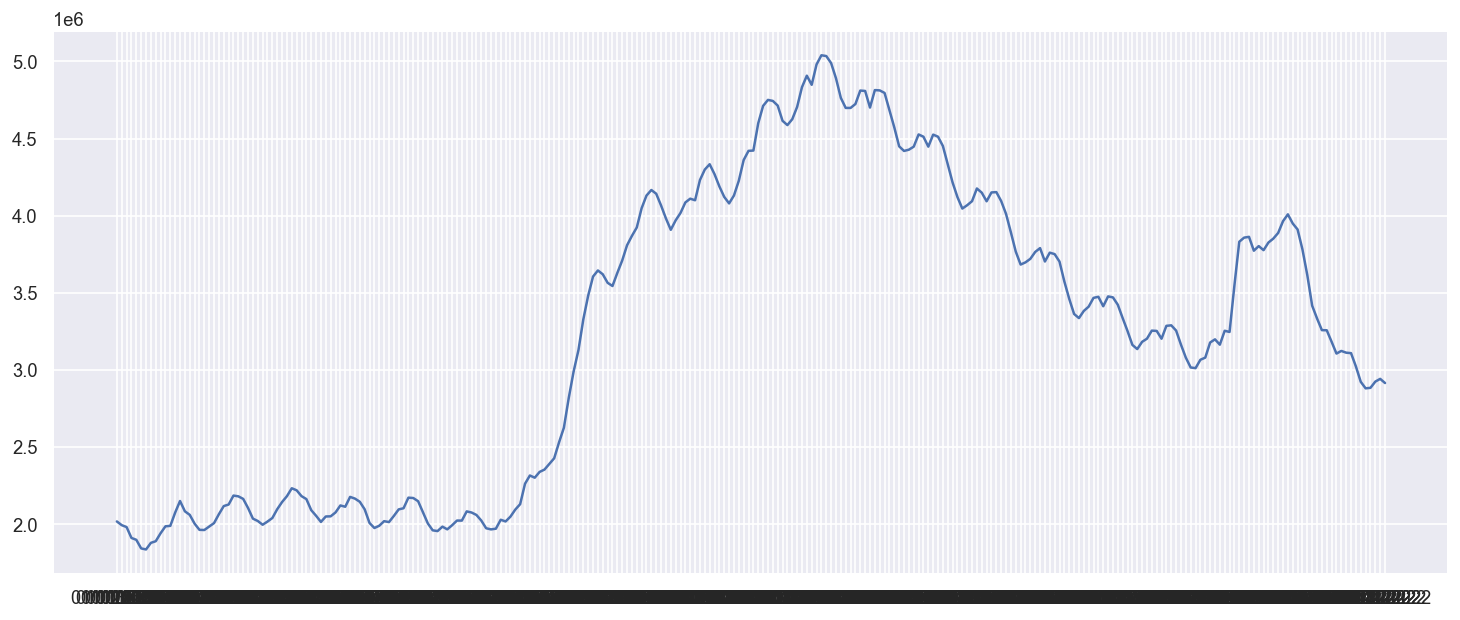

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['TOTAL'])
plt.show()

#### Vemos que no hay constancia ni en la media ni en la varianza

In [39]:
df_uneployment = df[['TOTAL']] # Maintain data.frame format for column
#df_ts = df_ts[1:4000]
df_uneployment

,TOTAL
0,2017389
1,1993273
2,1981006
3,1910453
4,1898285
...,...
257,2880582
258,2883812
259,2924240
260,2941919


<AxesSubplot:>

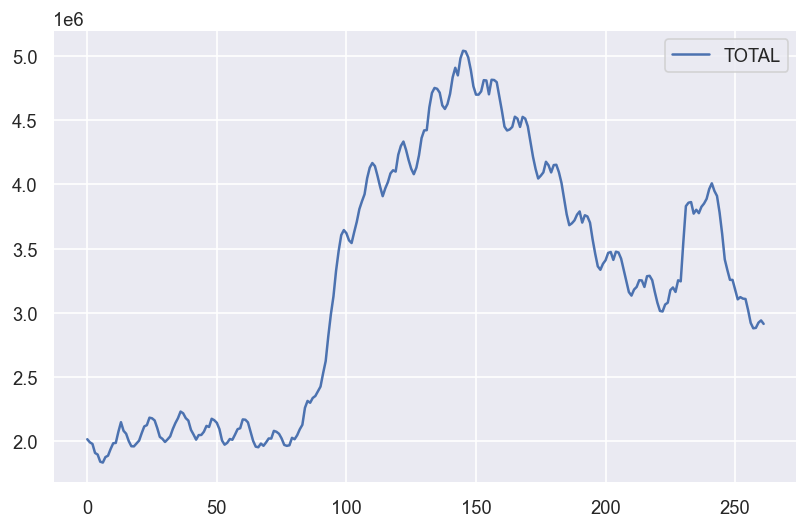

In [40]:
sns.lineplot(data=df_uneployment)

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


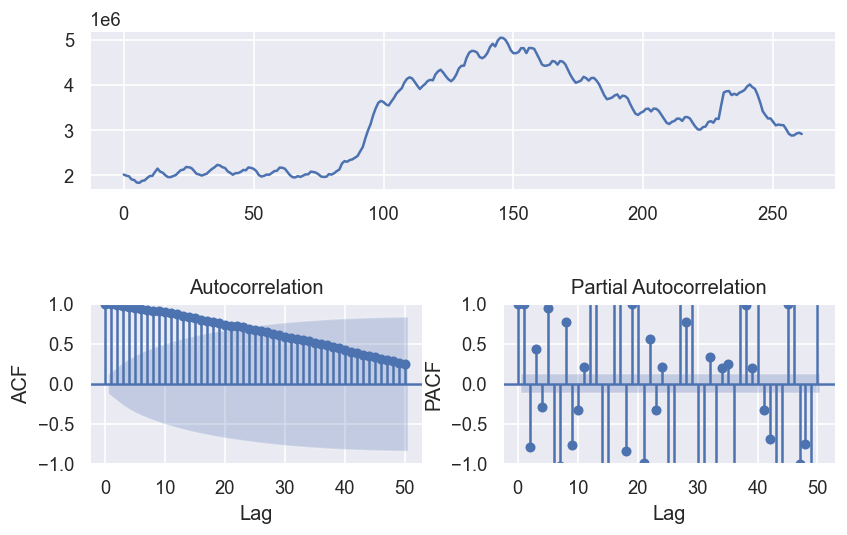

In [41]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_uneployment,lags=50)

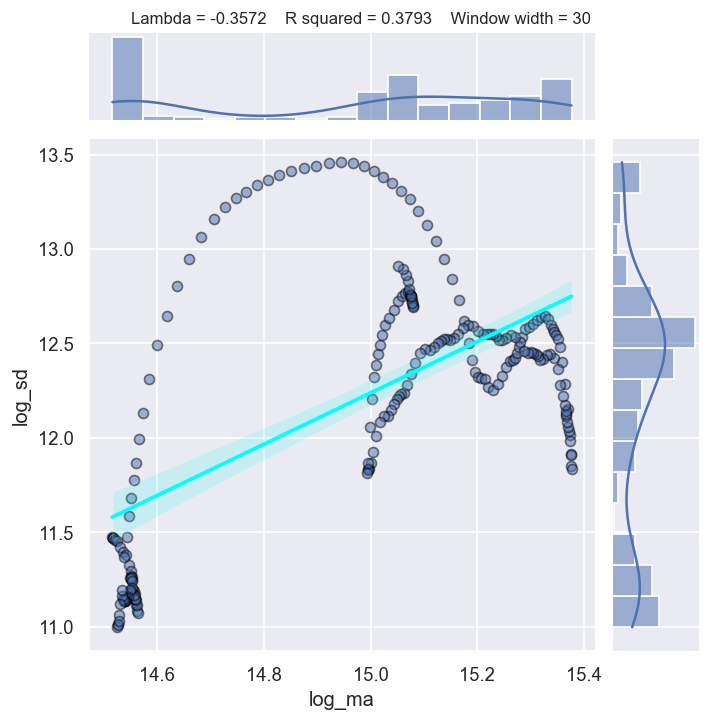

-0.3572263504966213

In [42]:
FT.boxcox_lambda_plot(df_uneployment, window_width=30)

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


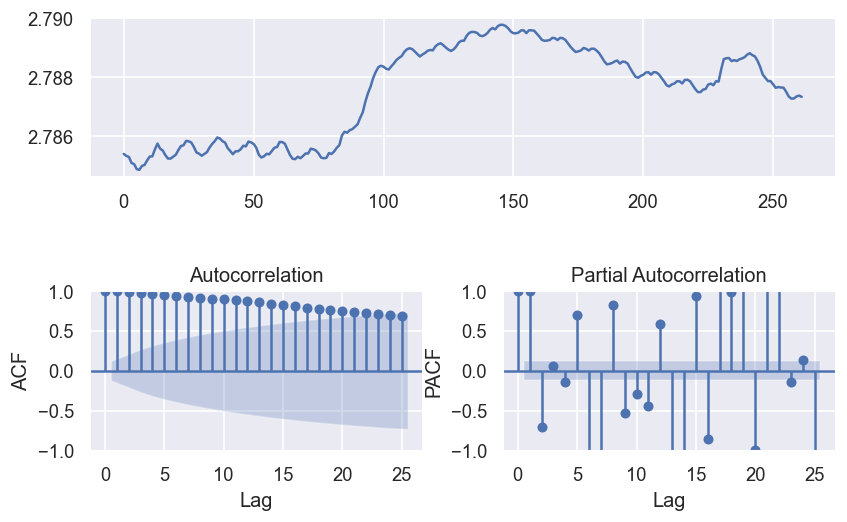

In [43]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = -0.357 #Select lambda
    z = st.boxcox(df_uneployment.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_uneployment.columns.values.tolist())
else:
    z = df_uneployment

# Plot transformed data
FT.ts_display(z)

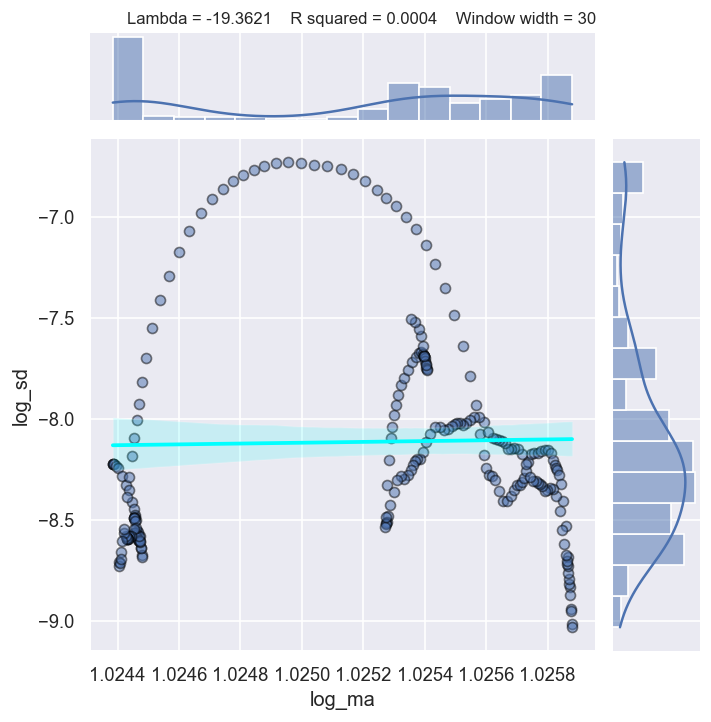

-19.362089449536366

In [44]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=30)

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


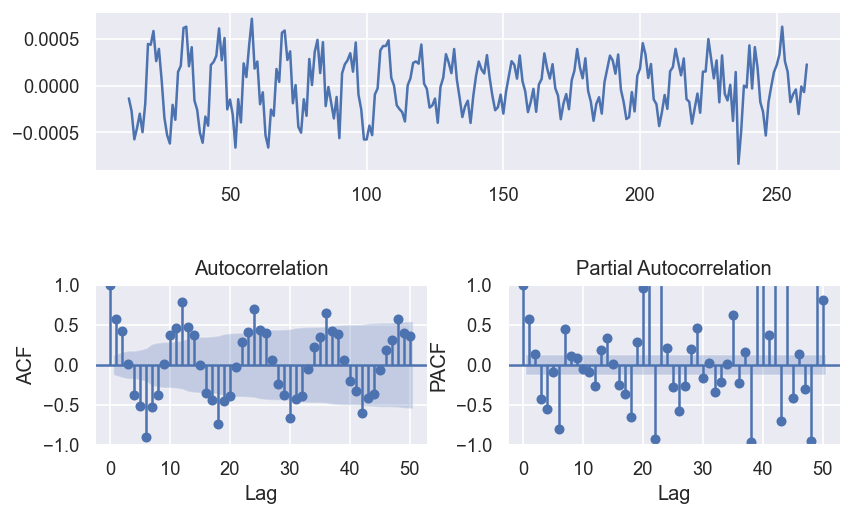

In [60]:
# Difference of the time series
d = 1 # diferenciacion regular. hacer iT y iT-1, si es dos cambiaria a 2
D = 2 # diferenciacion estacional. obterner mnueva seria q es iT - (iT-s)
S = 6 # Seasonality of 6 days
# 1,0,12 ves que tienes una tendencia estacional, no es estacionaria porq no decrece, asi que tienes que aumentar la
# diferenciacion estacional
# es la diferencia combinada entre el mes anterior y el año anterior

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)
# ACF tienes una barra y 3 significativa en el PACF, estacionalmente puede ser una media movil estacional

Hay que revisar la repeticion de arriba

In [63]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(2,1,0), # Regular components
                     # AR,si haces diferenciacion(d),MA
                     # primeros coeficiente en ACF y PACF. solo t fijas en los primeros coeficientes de PACF. AR orden 2
                    seasonal_order=(0, 1, 2, 6), # Seasonal components, (P, D, Q(MA), S)
                     # En el Q es donde hay mas simple, PACF en los multiplos de 12 hay 3 pero en el ACF solo hay 1
                     
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                  TOTAL   No. Observations:                  262
Model:             SARIMAX(2, 1, 0)x(0, 1, [1, 2], 6)   Log Likelihood                1926.830
Date:                                Wed, 23 Nov 2022   AIC                          -3843.660
Time:                                        16:11:23   BIC                          -3826.216
Sample:                                             0   HQIC                         -3836.633
                                                - 262                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4963   4.93e-19   1.01e+18      0.000       0.496       0.496
ar.

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat     lb_pvalue
25  94.421063  5.364753e-10


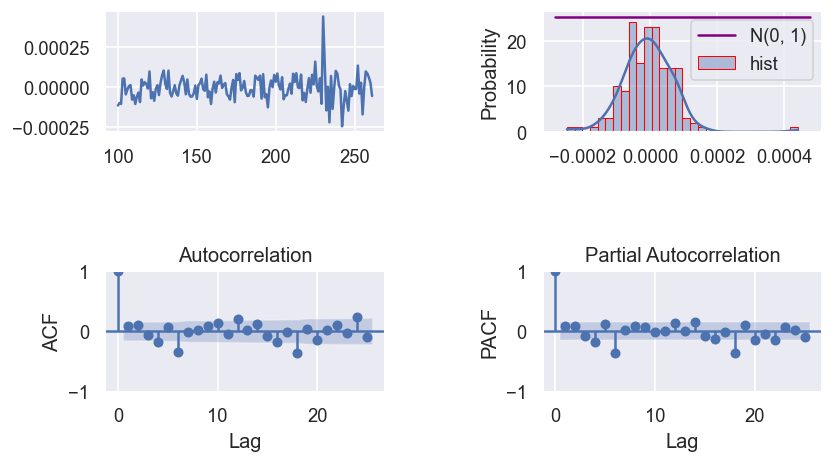

In [64]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

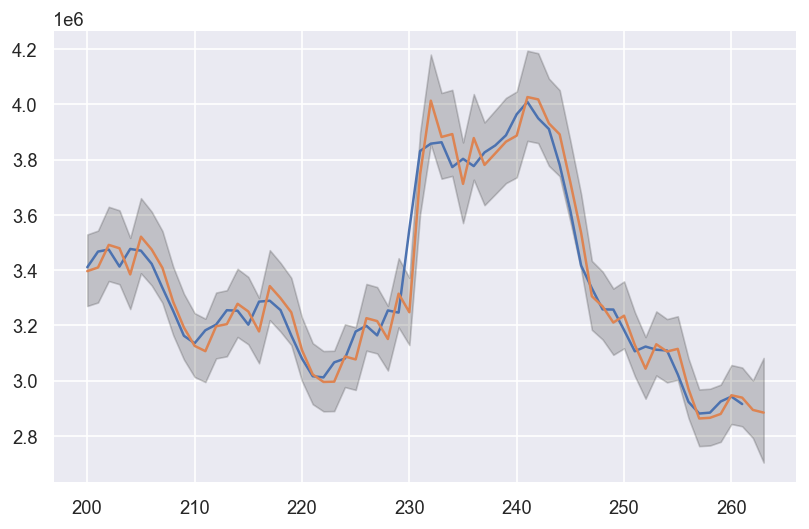

In [54]:
#Obtain forecasts for in-sample and out-of-sample
start = 200
horizon = 1
end = df_uneployment.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_uneployment.loc[start:])
plt.plot(yhat)
plt.show()